# Importing Libraries

In [1]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV

import math
import numpy as np
import random
import logging
import numbers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sksurv.tree import SurvivalTree
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sksurv.tree import SurvivalTree
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder

%matplotlib inline
%pylab inline
figsize(12,6)

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


C:\Users\Aditi\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# COBRA Base Estimator

In [2]:
logger = logging.getLogger('pycobra.cobra')


class Cobra(BaseEstimator):

    def __init__(self, random_state=None, epsilon=None, machine_list='basic'):
        self.random_state = random_state
        self.epsilon = epsilon
        self.machine_list = machine_list
    
    def fit(self, X, y, default=True, X_k=None, X_l=None, y_k=None, y_l=None):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.X_k_ = X_k
        self.X_l_ = X_l
        self.y_k_ = y_k
        self.y_l_ = y_l
        self.estimators_ = {}
        # set-up COBRA with default machines
        if default:
            self.split_data()
            self.load_default(machine_list=self.machine_list)
            self.load_machine_predictions()

        return self


    def set_epsilon(self, X_epsilon=None, y_epsilon=None, grid_points=50):
        # if no epsilon value is passed, we set up COBRA to perform CV and find an optimal epsilon.
        if self.epsilon is None and X_epsilon is not None:
            self.X_ = X_epsilon
            self.y_ = y_epsilon
            self.split_data()
            self.load_default()
            self.load_machine_predictions()
            a, size = sorted(self.all_predictions_), len(self.all_predictions_)
            res = [a[i + 1] - a[i] for i in range(size) if i+1 < size]
            emin = min(res)
            emax = max(a) - min(a)
            erange = np.linspace(emin, emax, grid_points)
            tuned_parameters = [{'epsilon': erange}]
            clf = GridSearchCV(self, tuned_parameters, scoring="neg_mean_squared_error")
            clf.fit(X_epsilon, y_epsilon)
            self.epsilon = clf.best_params_["epsilon"]
            self.estimators_, self.machine_predictions_ = {}, {}

    
    def pred_surv(self, X, alpha, info=False):
        # dictionary mapping machine to points selected
        select = {}
        for machine in self.estimators_:
            # machine prediction
            val = self.estimators_[machine].predict(X)
            select[machine] = set()
            # iterating from l to n
            # replace with numpy iteration
            for count in range(0, len(self.X_l_)):
                try:
                    # if value is close to prediction, select the indice
                    if math.fabs(self.machine_predictions_[machine][count] - val) <= self.epsilon:
                        select[machine].add(count)
                except (ValueError, TypeError) as e:
                    logger.info("Error in indice selection")
                    continue

        points = []
        # count is the indice number.
        for count in range(0, len(self.X_l_)):
            # row check is number of machines which picked up a particular point
            row_check = 0
            for machine in select:
                if count in select[machine]:
                    row_check += 1
            if row_check == alpha:
                points.append(count)

        # if no points are selected, return 0
        if len(points) == 0:
            if info:
                logger.info("No points were selected, prediction is 0")
                return (0, 0)
            return None

        # aggregate
        avg_surv = None
        # points = [pt for pt in points if self.y_l_[pt][0]]
        
        for point in points:
            for machine in select:
                val = self.estimators_[machine].predict_surv(self.X_l_[point].reshape(1,-1))[0]
                if avg_surv is None:
                    avg_surv = val
                else:
                    avg_surv += val
        avg_surv = avg_surv / avg_surv[0]

        if info:
            return avg_surv, points
        return avg_surv
    
    def predict_survival_function(self, X, alpha=None, info=False):

        # sets alpha as the total number of machines as a default value

        X = check_array(X)

        if alpha is None:
            alpha = len(self.estimators_)
        if X.ndim == 1:
            return self.pred_surv(X.reshape(1, -1), info=info, alpha=alpha)

        result = [None]*len(X)
        avg_points = 0
        index = 0
        for vector in X:
            if info:
                result[index], points = self.pred_surv(vector.reshape(1, -1), info=info, alpha=alpha)
                avg_points += len(points)
            else:
                result[index] = self.pred_surv(vector.reshape(1, -1), info=info, alpha=alpha)
            index += 1

        result = np.array(result)
        
        if info:
            avg_points = avg_points / len(X_array)
            return result, avg_points

        return result

    def split_data(self, k=None, l=None, shuffle_data=False):

        if shuffle_data:
            self.X_, self.y_ = shuffle(self.X_, self.y_, random_state=self.random_state)

        if k is None and l is None:
            k = int(len(self.X_) / 2)
            l = int(len(self.X_))

        if k is not None and l is None:
            l = len(self.X_) - k

        if l is not None and k is None:
            k = len(self.X_) - l

        self.X_k_ = self.X_[:k]
        self.X_l_ = self.X_[k:l]
        self.y_k_ = self.y_[:k]
        self.y_l_ = self.y_[k:l]

        return self


    def load_machine(self, machine_name, machine):
        self.estimators_[machine_name] = machine

        return self


    def load_machine_predictions(self, predictions=None):
        self.machine_predictions_ = {}
        self.all_predictions_ = np.array([])
        if predictions is None:
            for machine in self.estimators_:
                self.machine_predictions_[machine] = self.estimators_[machine].predict(self.X_l_)
                # all_predictions_ is used in the diagnostics class, and for initialising epsilon
                self.all_predictions_ = np.append(self.all_predictions_, self.machine_predictions_[machine])

        if predictions is not None:
            self.machine_predictions_ = predictions

        return self

# Constructing survival tree

In [3]:
class PyCobraSurvivalTree(SurvivalTree):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def predict(self, X):
        surv_func = super().predict_survival_function(X,return_array=True)
        mean = [0]*len(surv_func)
        for i in range(len(surv_func)):
            mean[i] = sum((self.event_times_[:-1]+self.event_times_[1:])*(surv_func[i,:-1]-surv_func[i,1:]))/2 + self.event_times_[-1]*surv_func[i,-1]
        return mean
    
    def predict_surv(self, X, return_array=True):
        return super().predict_survival_function(X,return_array=return_array)
    
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)

# Loading dataset and train test split

In [4]:
X, y = load_gbsg2()
X.loc[:, "tgrade"] = X.loc[:, "tgrade"].map(len).astype(int)
Xt = OneHotEncoder().fit_transform(X)
df_y = pd.DataFrame(data={'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

# Constructing COBRA model with survival trees as estimators

In [5]:
survivalCobra = Cobra(epsilon=1000)
survivalCobra.fit(X_train,y_train,default=False)
for i in range(4):
    survivalTree = PyCobraSurvivalTree(splitter='random', random_state=i)
    survivalTree.fit(X_train,y_train)
    survivalCobra.load_machine(f'survTree_{i:2d}',survivalTree)
eventTimes = survivalTree.event_times_
survivalCobra.split_data()
survivalCobra.load_machine_predictions()

Cobra(epsilon=1000)

In [6]:
y = survivalCobra.predict_survival_function(X_test)

# Calculating integrated brier score for the model

In [7]:
from scipy.interpolate import interp1d
from sksurv.metrics import integrated_brier_score
times = np.arange(80, 2300)
preds = []

for i in range(len(y)):
    step_fun = interp1d(eventTimes, y[i], kind='previous')
    preds.append(np.asarray([step_fun(t) for t in times]))

score = integrated_brier_score(y_test, y_test, preds, times)
print("The integrated brier score is " + str(score))

The integrated brier score is 0.1671782003861551


# Predicted survival function using COBRA

Text(0.5, 1.0, 'Survival Function')

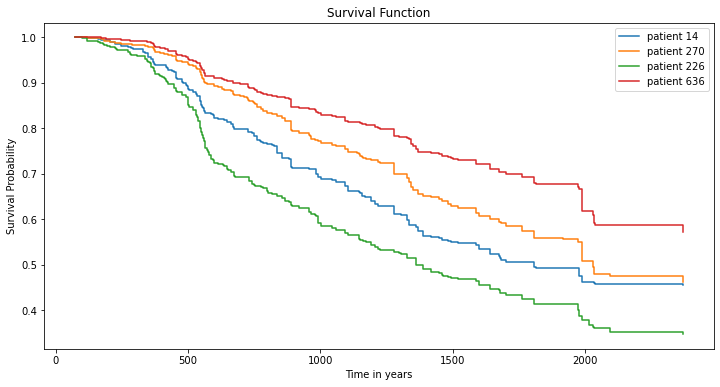

In [8]:
y_t = survivalCobra.predict_survival_function(X_test.iloc[0:4])
for i in range(len(y_t)):
    plt.step(eventTimes, y_t[i], where="post",label=f"patient {X_test.iloc[i].name}")

plt.xlabel("Time in years")
plt.ylabel("Survival Probability")
plt.legend()
plt.title('Survival Function')